# Initial Python Setup
First, we'll need to import the related libraries that will be used in this scirpt


In [1]:
import os
import pandas as pd
import requests as req
import numpy as np
import statsmodels.api as stapi
import statsmodels.formula.api as smf
import scipy.stats as st

from pandas import DataFrame
from zipfile import ZipFile
from io import BytesIO
from IPython.display import display
from matplotlib import rc as pltrc
from matplotlib import pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import RegressionResults, RegressionResultsWrapper

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Next, we'll set up some initial variables and configuration, such as links and display options


In [2]:
url = 'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2022.zip'
file_name = 'survey_results_public.csv'

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 75)

pltrc('font', size=10)

# Importing the Dataset
Here, we will download and extract the dataset. We'll be doing the entire process in-memory, so you will not need to worry about any additional files being saved to your computer

In [3]:
response = req.get(url)
zip_file = ZipFile(BytesIO(response.content))
df = pd.read_csv(BytesIO(zip_file.read(file_name)))

Now, the dataframe is stored in the `df` variable, and looks like the following:

In [4]:
display(df)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,CAD\tCanadian dollar,NaN,NaN,JavaScript;TypeScript,Rust;TypeScript,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,macOS,Windows Subsystem for Linux (WSL),Git,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very unfavorable,Collectives on Stack Overflow;Stack Overflow f...,Daily or almost daily,Yes,Daily or almost daily,Not sure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,5,Data scientist or machine learning specialist;...,20 to 99 employees,I have some influence,NaN,United Kingdom of Great Britain and Northern I...,GBP\tPound sterling,32000.0,Yearly,C#;C++;HTML/CSS;JavaScript;Python,C#;C++;HTML/CSS;JavaScript;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,Angular.js,Angular;Angular.js,Pandas,.NET,NaN,NaN,Notepad++;Visual Studio,Notepad++;Visual Studio,Windows,Windows,Git,Code editor,NaN,NaN,NaN,NaN,Microsoft Teams,Microsoft Teams,Very unfavorable,Collectives on Stack Overflow;Stack Overflow;S...,Multiple times per day,Yes,Multiple times per day,Neutral,25-34 years old,Man,No,Bisexual,White,None of the above,"I have a mood or emotional disorder (e.g., dep...",No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,40205.0
3,4,I am a developer by profession,"Employed, full-time",Fully remote,I don’t code outside of work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Books / Physical media;School (i.e., Universit...",NaN,NaN,20,17,"Developer, full-stack",100 to 499 employees,I have some influence,Other (please specify):,Israel,ILS\tIsraeli new shekel,60000.0,Monthly,C#;JavaScript;SQL;TypeScript,C#;SQL;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,ASP.NET;ASP.NET Core,ASP.NET;ASP.NET Core,.NET,.NET,NaN,NaN,Notepad++;Visual Studio;Visual Studio Code,Notepad++;Visual Studio;Visual Studio Code,Windows,Windows,Git,Code editor;Command-line;Version control hosti...,NaN,NaN,Jira Work Management;Trello,Jira Work Management;Trello,Slack;Zoom

# Data Cleaning
Now, the data won't work in the original state. As stated in the report, many of the variables are actually multi-selectable lists. The variables are stored as strings, using `;` as a separator.

We'll create new dataframes for each of these. In this step, we'll also need to rename some of the new columns to avoid including spaces or characters we can't use in regression.

In [5]:
df_languages = df["LanguageHaveWorkedWith"].str.get_dummies(';').rename(columns={
  "C#": "CSharp",
  "F#": "FSharp",
  "Bash/Shell": "Bash",
  "HTML/CSS": "HTML",
  "Objective-C": "ObjectiveC",
  "C++": "Cpp"
}).add_prefix("WorksIn_")

df_devtype = df["DevType"].str.get_dummies(";").rename(columns={
  "Academic researcher": "AcademicResearcher",
  "Cloud infrastructure engineer": "CloudInfrastructureEngineer",
  "Data or business analyst": "DataBusinessAnalyst",
  "Data scientist or machine learning specialist": "DataScientistMachineLearning",
  "Database administrator": "DatabaseAdministrator",
  "DevOps specialist": "DevOpsSpecialist",
  "Developer, QA or test": "DevQATest",
  "Developer, back-end": "DevBackend",
  "Developer, desktop or enterprise applications": "DevDesktopApps",
  "Developer, embedded applications or devices": "DevEmbedded",
  "Developer, front-end": "DevFrontend",
  "Developer, full-stack": "DevFullstack",
  "Developer, game or graphics": "DevGame",
  "Developer, mobile": "DevMobile",
  "Engineer, data": "DataEngineer",
  "Engineer, site reliability": "SiteReliabilityEngineer",
  "Engineering manager": "EngineerManager",
  "Marketing or sales professional": "MarketingSales",
  "Other (please specify):": "Other",
  "Product manager": "ProductManager",
  "Project manager":"ProjectManager",
  "Security professional": "Security",
  "Senior Executive (C-Suite, VP, etc.)": "SeniorExec",
  "System administrator": "SystemAdmin"
}).add_prefix("DevType_")
del df_devtype["DevType_Other"]

df_employment = df["Employment"].str.get_dummies(";").rename(columns={
  "Employed, full-time": "FullTime",
  "Employed, part-time": "PartTime",
  "I prefer not to say": "Unknown",
  "Independent contractor, freelancer, or self-employed": "SelfEmployed",
  "Not employed, and not looking for work": "UnemployedNotLooking",
  "Not employed, but looking for work": "UnemployedLooking",
  "Student, full-time": "StudentFullTime",
  "Student, part-time": "StudentPartTime"
}).add_prefix("Employed_")
del df_employment["Employed_Unknown"]

Each of these dataframes contain a column for every possible choice found in the dataset. For example, the `dummy_languages` contains each of the languages found in the dataset as follows:

In [6]:
display(df_languages)

,WorksIn_APL,WorksIn_Assembly,WorksIn_Bash,WorksIn_C,WorksIn_CSharp,WorksIn_Cpp,WorksIn_COBOL,WorksIn_Clojure,WorksIn_Crystal,WorksIn_Dart,WorksIn_Delphi,WorksIn_Elixir,WorksIn_Erlang,WorksIn_FSharp,WorksIn_Fortran,WorksIn_Go,WorksIn_Groovy,WorksIn_HTML,WorksIn_Haskell,WorksIn_Java,WorksIn_JavaScript,WorksIn_Julia,WorksIn_Kotlin,WorksIn_LISP,WorksIn_Lua,WorksIn_MATLAB,WorksIn_OCaml,WorksIn_ObjectiveC,WorksIn_PHP,WorksIn_Perl,WorksIn_PowerShell,WorksIn_Python,WorksIn_R,WorksIn_Ruby,WorksIn_Rust,WorksIn_SAS,WorksIn_SQL,WorksIn_Scala,WorksIn_Solidity,WorksIn_Swift,WorksIn_TypeScript,WorksIn_VBA
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73263,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
73264,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
73265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
73266,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


If the person indicated that they have worked with the language, there will be a `1`. Otherwise, there will be a `0`.

Now, we can simply overwrite `df` to append these sub-dataframes into the main dataframe

In [7]:
df = pd.concat([df,df_languages, df_devtype, df_employment], axis = 1)

Next, some of the numeric columns have entries for extremities. For example, the `YearsCode` column can have the value `"Less than 1 year"` or `"More than 50 years"`, which can be problematic if we try to use them in our regression.

For simplification, we'll assume that `"Less than 1 year"` is `0`, and `"More than 50 years"` is `50`


In [8]:
df["NumYearsCode"] = pd.to_numeric(
  df["YearsCode"].replace({
    "Less than 1 year": 0,
    "More than 50 years": 50
  })
)

df["NumYearsCodePro"] = pd.to_numeric(
  df["YearsCodePro"].replace({
    "Less than 1 year": 0,
    "More than 50 years": 50
  })
)

Similarly, the text data for education level is bloated, so we will be replacing those in order to make our regression outputs cleaner

In [9]:
df["EducationLevel"] = df["EdLevel"].replace({
  "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "MastersDegree",
  "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "BachelorsDegree",
  "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "SecondarySchool",
  "Some college/university study without earning a degree": "SomeCollege",
  "Something else": "SomethingElse",
  "Primary/elementary school": "PrimarySchool",
  "Other doctoral degree (Ph.D., Ed.D., etc.)": "DoctoralDegree",
  "Associate degree (A.A., A.S., etc.)": "AssociatesDegree",
  "Professional degree (JD, MD, etc.)": "ProfessionalDegree"
})

# Filtering Data
Not all of the data can be useful to us. Entries come from across the world, get paid in different currencies, and not to mention some may put in false information. 

In order to get a dataset we can reliably use, we will first restrict our analysis on individuals in the United States. 

Next, we'll only use individuals who have the `"ConvertedCompYearly"` variable filled in. It appears that some of the outlier do not have this variable, so it may be StackOverflow's filtering to remove significant outliers

We will also remove any entries with any "unknown" values, such as having an unknown employment status

In [10]:
df_filtered = df[
  (df["Country"] == "United States of America") & 
  (df["ConvertedCompYearly"].notna()) &
  (df["ConvertedCompYearly"] < 1000000)
]

Our data is now filtered properly, and ready to be analyzed

In [11]:
display(df_filtered)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly,WorksIn_APL,WorksIn_Assembly,WorksIn_Bash,WorksIn_C,WorksIn_CSharp,WorksIn_Cpp,WorksIn_COBOL,WorksIn_Clojure,WorksIn_Crystal,WorksIn_Dart,WorksIn_Delphi,WorksIn_Elixir,WorksIn_Erlang,WorksIn_FSharp,WorksIn_Fortran,WorksIn_Go,WorksIn_Groovy,WorksIn_HTML,WorksIn_Haskell,WorksIn_Java,WorksIn_JavaScript,WorksIn_Julia,WorksIn_Kotlin,WorksIn_LISP,WorksIn_Lua,WorksIn_MATLAB,WorksIn_OCaml,WorksIn_ObjectiveC,WorksIn_PHP,WorksIn_Perl,WorksIn_PowerShell,WorksIn_Python,WorksIn_R,WorksIn_Ruby,WorksIn_Rust,WorksIn_SAS,WorksIn_SQL,WorksIn_Scala,WorksIn_Solidity,WorksIn_Swift,WorksIn_TypeScript,WorksIn_VBA,DevType_AcademicResearcher,DevType_Blockchain,DevType_CloudInfrastructureEngineer,DevType_DataBusinessAnalyst,DevType_DataScientistMachineLearning,DevType_DatabaseAdministrator,DevType_Designer,DevType_DevOpsSpecialist,DevType_DevQATest,DevType_DevBackend,DevType_DevDesktopApps,DevType_DevEmbedded,DevType_DevFrontend,DevType_DevFullstack,DevType_DevGame,DevType_DevMobile,DevType_Educator,DevType_DataEngineer,DevType_SiteReliabilityEngineer,DevType_EngineerManager,DevType_MarketingSales,DevType_ProductManager,DevType_ProjectManager,DevType_Scientist,DevType_Security,DevType_SeniorExec,DevType_Student,DevType_SystemAdmin,Employed_FullTime,Employed_PartTime,Employed_SelfEmployed,Employed_UnemployedNotLooking,Employed_UnemployedLooking,Employed_Retired,Employed_StudentFullTime,Employed_StudentPartTime,NumYearsCode,NumYearsCodePro,EducationLevel
11,12,"I am not primarily a developer, but I write co...","Employed, full-time;Independent contractor, fr...",Fully remote,Hobby;Contribute to open-source projects;Freel...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,NaN,12,10,Engineering manager,20 to 99 employees,I have some influence,Start a free trial;Ask developers I know/work ...,United States of America,USD\tUnited States dollar,194400.0,Yearly,C#;HTML/CSS;JavaScript;PowerShell;Python;Rust;SQL,C++;Go;HTML/CSS;JavaScript;Lua;Rust;TypeScript,Couchbase;CouchDB;Microsoft SQL Server;MongoDB...,Elasticsearch;MongoDB;Redis;SQLite,AWS;Microsoft Azure,AWS;DigitalOcean;Firebase;Linode,ASP.NET;ASP.NET Core ;Express;Node.js;Vue.js,ASP.NET Core ;Node.js;Nuxt.js;React.js;Vue.js,.NET;Keras;NumPy;Pandas;Scikit-learn;TensorFlo...,Keras;NumPy;Pandas;Scikit-learn;TensorFlow;Tor...,Docker;Homebrew;Kubernetes,Docker;Homebrew;Kubernetes;Pulumi;Terraform,IPython/Jupyter;Neovim;Visual Studio;Visual St...,IPython/Jupyter;Neovim;Visual Studio Code,Linux-based;macOS;Windows,Linux-based;macOS,Git,Code editor;Dedicated version control GUI appl...,NaN,NaN,Confluence;Jira Work Management;Notion;Trello,Notion;Trello,Cisco Webex Teams;Google Chat;Microsoft Teams;...,Slack,Unfavorable,Stack Ove

# Helper Functions

To make things easier, I'll create a bunch of functions here that help automate the displaying of plots (which can be copied into the report).



This function helps us by simply removing the first section of our new variables (so `WorksIn_Python` results in `Python`)


In [12]:
def removePrefix(string: str):
  return string[string.find('_')+1:]

This function will help visualize the effects of each column. By default, it will be set to show the languages, but it is configurable for my needs further on

In [13]:
def showCoefficientGraph(
    regression: RegressionResultsWrapper, 
    columns: list[str] = list(df_languages.columns),
    fig_size = (30,10),
    y_scale_factor = 1,
    ylabel="Coefficient",
    xlabel="Variable",
    remove_underscore = True,
    replace_underscore_with_space = True,
    font_size=20,
    title="Variable Coefficients",
    rotate_xticks = -90,
    show_stddev = False,
    show_grid = True,
    tick_scale = 10,
    scale = True
  ):



  reg: RegressionResults = regression #type: ignore
  table: pd.DataFrame = reg.summary2().tables[1]
  table = table[table.index.isin(columns)]
  if show_stddev:
    table["Coef."] = np.abs(table["Coef."] / table["Std.Err."])
  table = table.sort_values(by=["Coef."])
  
  
  if remove_underscore:
    table = table.set_axis([removePrefix(axis) for axis in list(table.index)], axis='index')
  elif replace_underscore_with_space:
    table = table.set_axis([axis.replace('_',' ') for axis in list(table.index)], axis='index')

  pltrc('font', size=font_size)
  plt.figure(figsize = fig_size)
  plt.xticks(rotation=rotate_xticks)
  barcontainer = plt.bar(table.index,table["Coef."] * y_scale_factor)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)

  values = table["Coef."] * y_scale_factor

  mn = (int(min(values)) // tick_scale) * tick_scale - tick_scale
  mx = (int(max(values)) // tick_scale) * tick_scale + tick_scale

  if scale:
    plt.yticks(np.arange(mn, mx+1, tick_scale))

  if title:
    plt.title(title)
  
  if show_grid:
    plt.grid(color='black', linestyle=':', linewidth=2, axis='y', alpha=0.7)

  if show_stddev:
    for a,color in [(0.90,'red'),(0.95,'green'),(0.99,'purple')]:
      plt.axhline(y = st.norm.interval(confidence=a)[1], label = f'{a * 100}% Confidence Interval', color=color)
    plt.legend(loc='upper left')

  return plt


Similarly, we'll need a function to display the summary (with additional features)

In [14]:
def display_summary(
    regression: RegressionResultsWrapper, 
    remove_underscore = True,
    replace_underscore_with_space = True,
  ):
  reg: RegressionResults = regression #type: ignore
  tables = reg.summary2().tables
  table: pd.DataFrame = tables[1]

  if remove_underscore:
    table = table.set_axis([removePrefix(axis) for axis in list(table.index)], axis='index')
  elif replace_underscore_with_space:
    table = table.set_axis([axis.replace('_',' ') for axis in list(table.index)], axis='index')

  return table
  

Additionally, we'll make a function that will export the table into a latex longtable

In [15]:
def to_longtable(
    table: pd.DataFrame,
    cols: list[str] = ["index", "Coef.", "Std.Err."],
    width: list[float] = [0.4,0.3,0.3],
  ):
  df: DataFrame = table

  if "index" in cols:
    df.reset_index(inplace=True)
    df["index"] = [removePrefix(item) for item in df["index"]]

  # df = df.set_axis([removePrefix(axis) for axis in list(df.index)], axis='index')
  

  columns = [table[col] for col in cols]

  bs = chr(92)
  nl = '\n'

  def format(item):
    if type(item) in [int, str, np.float64, np.float32, np.float16, np.int64, np.int32, np.int16]:
      return f'${item}$'
    else:
      return str(item)

  return (
f"""{bs}begin{{longtable}}{{|{'|'.join([f'R{{{d}{bs}linewidth}}' for d in width])}|}}
{bs}hline
{' & '.join([f'{bs}textbf{{{name if name != "index" else "Coefficient"}}}' for name in cols])} {bs}{bs}

{bs}hline
{f"{bs}{bs}{nl}{bs}hline{nl}".join([
  ' & '.join([format(col[i]) for col in columns])
  for i in range(len(columns[0]))
])} {bs}{bs}
{bs}hline
{bs}end{{longtable}}
"""
  )
  

We'll also need to be able to get the columns from the sub-dataframes

In [16]:
def cols(df: pd.DataFrame) -> list[str]:
  return list(df.columns)

And a way to join them into a `" + "` separated string

In [17]:
def add(vals: list[str]) -> str:
  return " + ".join(vals)

# Inspecting Data Distribution

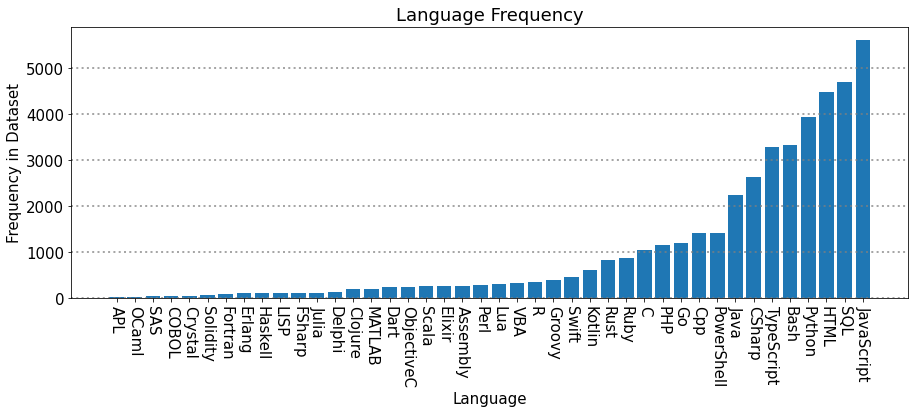

In [18]:
pltrc('font', size=15)
plt.figure(figsize = (15,5))
df_dist = df_filtered[cols(df_languages)].sum().sort_values()
df_dist = df_dist.set_axis([removePrefix(axis) for axis in list(df_dist.index)], axis='index')
plt.title("Language Frequency")
plt.xlabel("Language")
plt.ylabel("Frequency in Dataset")
plt.xticks(rotation=-90)
plt.grid(color='grey', linestyle=':', linewidth=2, axis='y', alpha=0.7)
plt.bar(df_dist.index, df_dist)
plt.show()

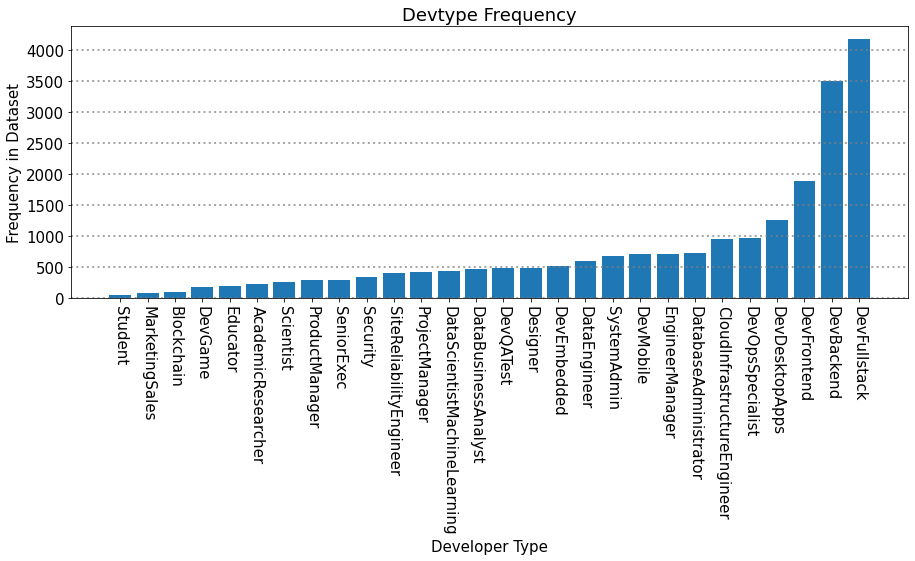

In [19]:
pltrc('font', size=15)
plt.figure(figsize = (15,5))
df_dist = df_filtered[cols(df_devtype)].sum().sort_values()
df_dist = df_dist.set_axis([removePrefix(axis) for axis in list(df_dist.index)], axis='index')
plt.title("Devtype Frequency")
plt.xlabel("Developer Type")
plt.ylabel("Frequency in Dataset")
plt.xticks(rotation=-90)
plt.grid(color='grey', linestyle=':', linewidth=2, axis='y', alpha=0.7)
plt.bar(df_dist.index, df_dist)
plt.show()

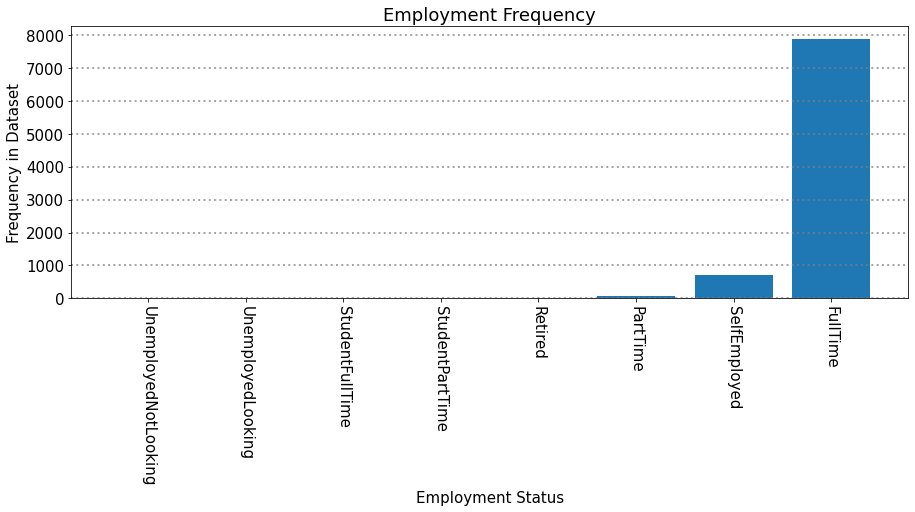

In [20]:
pltrc('font', size=15)
plt.figure(figsize = (15,5))
df_dist = df_filtered[cols(df_employment)].sum().sort_values()
df_dist = df_dist.set_axis([removePrefix(axis) for axis in list(df_dist.index)], axis='index')
plt.title("Employment Frequency")
plt.xlabel("Employment Status")
plt.ylabel("Frequency in Dataset")
plt.xticks(rotation=-90)
plt.grid(color='grey', linestyle=':', linewidth=2, axis='y', alpha=0.7)
plt.bar(df_dist.index, df_dist)
plt.show()

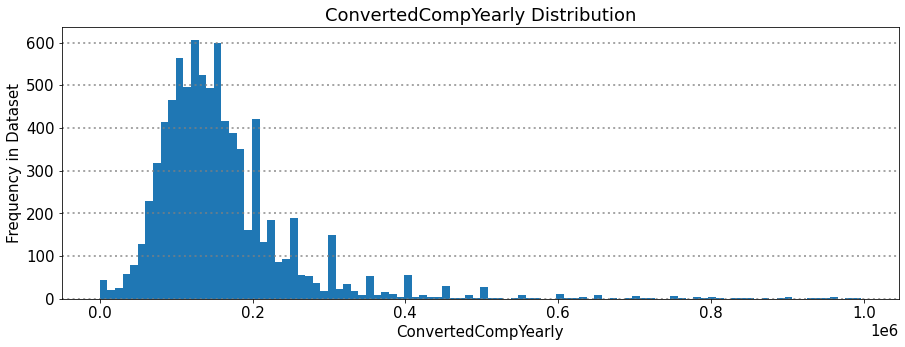

In [21]:
# Create a distribution plot for ConvertdCompYearly
pltrc('font', size=15)
plt.figure(figsize = (15,5))
plt.title("ConvertedCompYearly Distribution")
plt.xlabel("ConvertedCompYearly")
plt.ylabel("Frequency in Dataset")
plt.grid(color='grey', linestyle=':', linewidth=2, axis='y', alpha=0.7)
plt.hist(df_filtered["ConvertedCompYearly"], bins=100)
plt.show()


# Analysis
Now, we get into the fun part. I won't have much of the explanation here, since that's the purpose of the report. However, I'll try to include a basic idea of what each part is


In [22]:
model_1 = ols(f"np.log(ConvertedCompYearly) ~ {add(cols(df_languages))}", data = df_filtered).fit()

In [23]:
print(to_longtable(model_1.summary2().tables[1]))

\begin{longtable}{|R{0.4\linewidth}|R{0.3\linewidth}|R{0.3\linewidth}|}
\hline
\textbf{Coefficient} & \textbf{Coef.} & \textbf{Std.Err.} \\

\hline
$Intercept$ & $11.827803444105193$ & $0.018573846032009973$\\
\hline
$APL$ & $-0.3081318751934678$ & $0.13544699455891196$\\
\hline
$Assembly$ & $-0.004440133600747992$ & $0.04529041459498248$\\
\hline
$Bash$ & $0.08783835306836317$ & $0.016563574616096116$\\
\hline
$C$ & $-0.02592747201633292$ & $0.02772204661679131$\\
\hline
$CSharp$ & $-0.01802062922269684$ & $0.018531078578646366$\\
\hline
$Cpp$ & $0.007029955548172552$ & $0.023593287656551422$\\
\hline
$COBOL$ & $-0.09298843110473298$ & $0.09418884892596704$\\
\hline
$Clojure$ & $0.14362091298278284$ & $0.04818413318828497$\\
\hline
$Crystal$ & $-0.23406926782642265$ & $0.0945454795560851$\\
\hline
$Dart$ & $-0.04604688233804649$ & $0.04430947512536768$\\
\hline
$Delphi$ & $0.0014520978297333786$ & $0.05912164345150833$\\
\hline
$Elixir$ & $0.13639914158836952$ & $0.048425723139664895$

In [24]:
model_1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:              OLS                         Adj. R-squared:     0.046     
Dependent Variable: np.log(ConvertedCompYearly) AIC:                16917.5181
Date:               2022-12-17 18:13            BIC:                17219.2595
No. Observations:   8244                        Log-Likelihood:     -8415.8   
Df Model:           42                          F-statistic:        10.50     
Df Residuals:       8201                        Prob (F-statistic): 6.66e-66  
R-squared:          0.051                       Scale:              0.45340   
--------------------------------------------------------------------------------
                       Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
--------------------------------------------------------------------------------
Intercept             11.8278     0.0186   636.7988   0.0000   11.7914   11.8642
WorksIn_APL           -0.3081     0.1354    -2.2749   0.0229   -0.5736   -0.0426
WorksIn_Assembly      -0.0044     0.0453    -0.0980   0.9219   -0.0932    0.0843
WorksIn_Bash           0.0878     0.0166     5.3031   0.0000    0.0554    0.1203
WorksIn_C             -0.0259     0.0277    -0.9353   0.3497   -0.0803    0.0284
WorksIn_CSharp        -0.0180     0.0185    -0.9725   0.3309   -0.0543    0.0183
WorksIn_Cpp            0.0070     0.0236     0.2980   0.7657   -0.0392    0.0533
WorksIn_COBOL         -0.0930     0.0942    -0.9873   0.3235   -0.2776    0.0916
WorksIn_Clojure        0.1436     0.0482     2.9807   0.0029    0.0492    0.2381
WorksIn_Crystal       -0.2341     0.0945    -2.4757   0.0133   -0.4194   -0.0487
WorksIn_Dart          -0.0460     0.0443    -1.0392   0.2987   -0.1329    0.0408
WorksIn_Delphi         0.0015     0.0591     0.0246   0.9804   -0.1144    0.1173
WorksIn_Elixir         0.1364     0.0484     2.8167   0.0049    0.0415    0.2313
WorksIn_Erlang         0.0261     0.0752     0.3475   0.7282   -0.1212    0.1735
WorksIn_FSharp         0.0343     0.0617     0.5563   0.5780   -0.0866    0.1553
WorksIn_Fortran       -0.2148     0.0732    -2.9351   0.0033   -0.3583   -0.0714
WorksIn_Go             0.1488     0.0222     6.7060   0.0000    0.1053    0.1923
WorksIn_Groovy         0.0424     0.0363     1.1676   0.2430   -0.0288    0.1135
WorksIn_HTML          -0.1172     0.0184    -6.3675   0.0000   -0.1533   -0.0811
WorksIn_Haskell       -0.0819     0.0657    -1.2466   0.2126   -0.2107    0.0469
WorksIn_Java           0.0577     0.0182     3.1720   0.0015    0.0220    0.0933
WorksIn_JavaScript    -0.0363     0.0206    -1.7640   0.0778   -0.0766    0.0040
WorksIn_Julia         -0.0937     0.0630    -1.4868   0.1371   -0.2173    0.0298
WorksIn_Kotlin        -0.0026     0.0303    -0.0849   0.9323   -0.0619    0.0568
WorksIn_LISP          -0.0343     0.0674    -0.5098   0.6102   -0.1664    0.0977
WorksIn_Lua           -0.0788     0.0399    -1.9738   0.0484   -0.1570   -0.0005
WorksIn_MATLAB        -0.0469     0.0489    -0.9575   0.3383   -0.1428    0.0491
WorksIn_OCaml          0.0129     0.1230     0.1045   0.9167   -0.2283    0.2540
WorksIn_ObjectiveC     0.1615     0.0495     3.2607   0.0011    0.0644    0.2586
WorksIn_PHP           -0.1573     0.0223    -7.0415   0.0000   -0.2010   -0.1135
WorksIn_Perl           0.0413     0.0415     0.9952   0.3197   -0.0401    0.1227
WorksIn_PowerShell    -0.0245     0.0218    -1.1253   0.2605   -0.0672    0.0182
WorksIn_Python        -0.0069     0.0162    -0.4246   0.6712   -0.0387    0.0249
WorksIn_R             -0.1143     0.0387    -2.9520   0.0032   -0.1901   -0.0384
WorksIn_Ruby           0.0871     0.0249     3.5060   0.0005    0.0384    0.1359
WorksIn_Rust           0.0282     0.0262     1.0789   0.2807   -0.0231    0.0796
WorksIn_SAS           -0.0691     0.0982    -0.7041   0.4814   -0.2616    0.1233
WorksIn_SQL            0

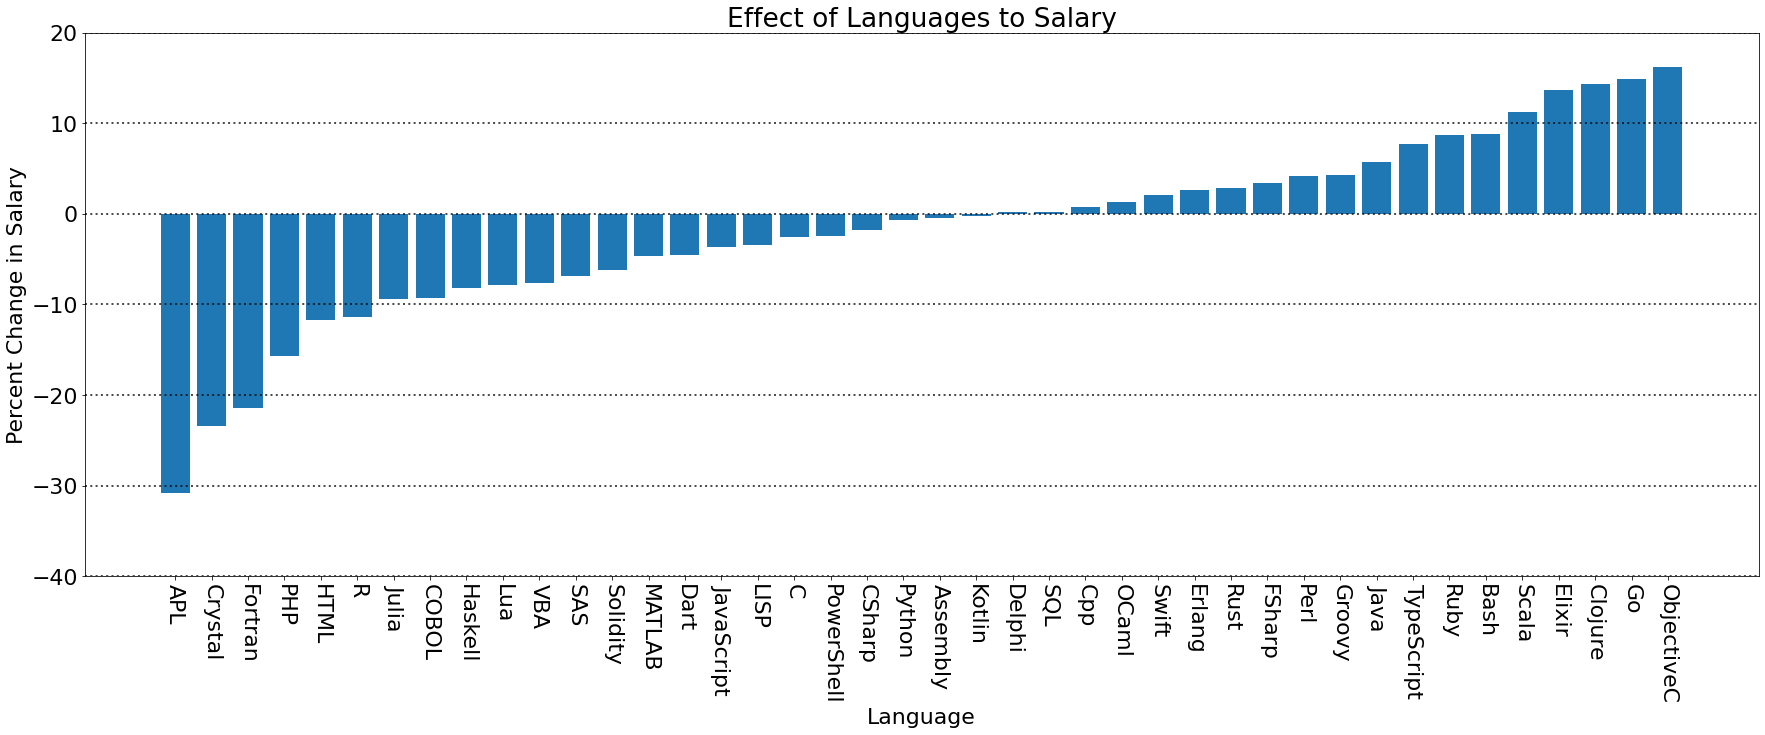

In [25]:
showCoefficientGraph(
  model_1,
  columns = cols(df_languages),
  y_scale_factor=100,
  font_size=22,
  title="Effect of Languages to Salary",
  xlabel="Language",
  ylabel="Percent Change in Salary"
).show()

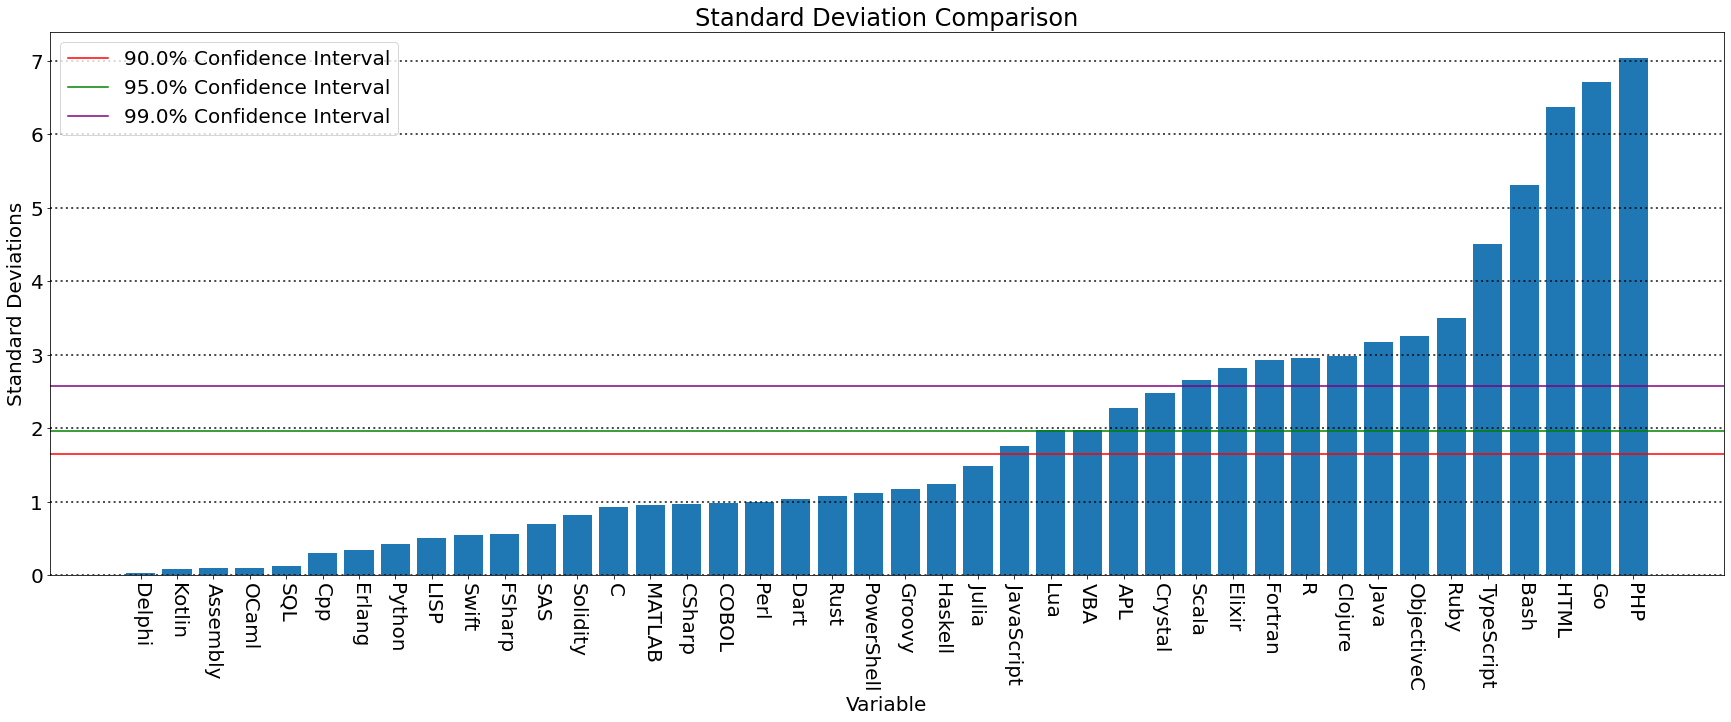

In [26]:
showCoefficientGraph(
  model_1,
  columns = cols(df_languages),
  scale=False,
  show_stddev=True,
  title="Standard Deviation Comparison",
  ylabel="Standard Deviations",
  xlabel="Variable",
  font_size=20
).show()

In [27]:
model_2 = ols(f"np.log(ConvertedCompYearly) ~ {add(cols(df_languages) + cols(df_devtype))}", data = df_filtered).fit()

In [28]:
print(to_longtable(model_2.summary2().tables[1]))

\begin{longtable}{|R{0.4\linewidth}|R{0.3\linewidth}|R{0.3\linewidth}|}
\hline
\textbf{Coefficient} & \textbf{Coef.} & \textbf{Std.Err.} \\

\hline
$Intercept$ & $11.794401536957624$ & $0.0197901626629589$\\
\hline
$APL$ & $-0.27434589797041764$ & $0.13393222965742863$\\
\hline
$Assembly$ & $-0.004240112102179866$ & $0.044843749686130974$\\
\hline
$Bash$ & $0.07264754392886497$ & $0.01653034230939305$\\
\hline
$C$ & $-0.003183196020366987$ & $0.027865397705846204$\\
\hline
$CSharp$ & $-0.022755075697375574$ & $0.0185571469733731$\\
\hline
$Cpp$ & $0.020130655735869453$ & $0.023763200309963543$\\
\hline
$COBOL$ & $-0.07063135167846707$ & $0.09251998030925647$\\
\hline
$Clojure$ & $0.12299744180301099$ & $0.04736110907065278$\\
\hline
$Crystal$ & $-0.22576065594303962$ & $0.09301669809043288$\\
\hline
$Dart$ & $-0.03730188675428392$ & $0.04401675201249393$\\
\hline
$Delphi$ & $0.0364157862568527$ & $0.05906019294954842$\\
\hline
$Elixir$ & $0.10278267793945656$ & $0.0476111576001096$\\
\

In [29]:
model_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
=====================================================================================
Model:                 OLS                           Adj. R-squared:       0.083     
Dependent Variable:    np.log(ConvertedCompYearly)   AIC:                  16617.5933
Date:                  2022-12-17 18:13              BIC:                  17115.8174
No. Observations:      8244                          Log-Likelihood:       -8237.8   
Df Model:              70                            F-statistic:          11.71     
Df Residuals:          8173                          Prob (F-statistic):   2.98e-121 
R-squared:             0.091                         Scale:                0.43573   
-------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------
Intercept                            11.7944   0.0198 595.9729 0.0000 11.7556 11.8332
WorksIn_APL                          -0.2743   0.1339  -2.0484 0.0406 -0.5369 -0.0118
WorksIn_Assembly                     -0.0042   0.0448  -0.0946 0.9247 -0.0921  0.0837
WorksIn_Bash                          0.0726   0.0165   4.3948 0.0000  0.0402  0.1051
WorksIn_C                            -0.0032   0.0279  -0.1142 0.9091 -0.0578  0.0514
WorksIn_CSharp                       -0.0228   0.0186  -1.2262 0.2202 -0.0591  0.0136
WorksIn_Cpp                           0.0201   0.0238   0.8471 0.3969 -0.0265  0.0667
WorksIn_COBOL                        -0.0706   0.0925  -0.7634 0.4452 -0.2520  0.1107
WorksIn_Clojure                       0.1230   0.0474   2.5970 0.0094  0.0302  0.2158
WorksIn_Crystal                      -0.2258   0.0930  -2.4271 0.0152 -0.4081 -0.0434
WorksIn_Dart                         -0.0373   0.0440  -0.8474 0.3968 -0.1236  0.0490
WorksIn_Delphi                        0.0364   0.0591   0.6166 0.5375 -0.0794  0.1522
WorksIn_Elixir                        0.1028   0.0476   2.1588 0.0309  0.0095  0.1961
WorksIn_Erlang                        0.0144   0.0741   0.1940 0.8462 -0.1308  0.1596
WorksIn_FSharp                        0.0086   0.0606   0.1421 0.8870 -0.1102  0.1274
WorksIn_Fortran                      -0.1568   0.0732  -2.1422 0.0322 -0.3002 -0.0133
WorksIn_Go                            0.0973   0.0223   4.3663 0.0000  0.0536  0.1410
WorksIn_Groovy                        0.0271   0.0358   0.7573 0.4489 -0.0431  0.0974
WorksIn_HTML                         -0.0809   0.0185  -4.3766 0.0000 -0.1171 -0.0447
WorksIn_Haskell                      -0.0586   0.0646  -0.9072 0.3643 -0.1852  0.0680
WorksIn_Java                          0.0497   0.0181   2.7517 0.0059  0.0143  0.0851
WorksIn_JavaScript                   -0.0260   0.0208  -1.2518 0.2107 -0.0667  0.0147
WorksIn_Julia                        -0.0703   0.0628  -1.1184 0.2634 -0.1934  0.0529
WorksIn_Kotlin                       -0.0034   0.0301  -0.1142 0.9091 -0.0625  0.0557
WorksIn_LISP                         -0.0243   0.0664  -0.3665 0.7140 -0.1544  0.1057
WorksIn_Lua                          -0.0773   0.0393  -1.9673 0.0492 -0.1542 -0.0003
WorksIn_MATLAB                        0.0022   0.0486   0.0445 0.9645 -0.0932  0.0975
WorksIn_OCaml                         0.0407   0.1209   0.3363 0.7367 -0.1964  0.2777
WorksIn_ObjectiveC                    0.1747   0.0493   3.5451 0.0004  0.0781  0.2712
WorksIn_PHP                          -0.1414   0.0222  -6.3674 0.0000 -0.1849 -0.0979
WorksIn_Perl                          0.0426   0.0409   1.0418 0.2976 -0.0376  0.1229
WorksIn_PowerShell                   -0.0121   0.0217  -0.5596 0.5758 -0.0546  0.0304
WorksIn_Python                       -0.0190   0.0163  -1.1634 0.2447 -0.0511  0.0130
WorksIn_R                            -0.0983   0.0401  -2.4509 0.0143 -0.1770 -0.0197
WorksIn_Ruby          

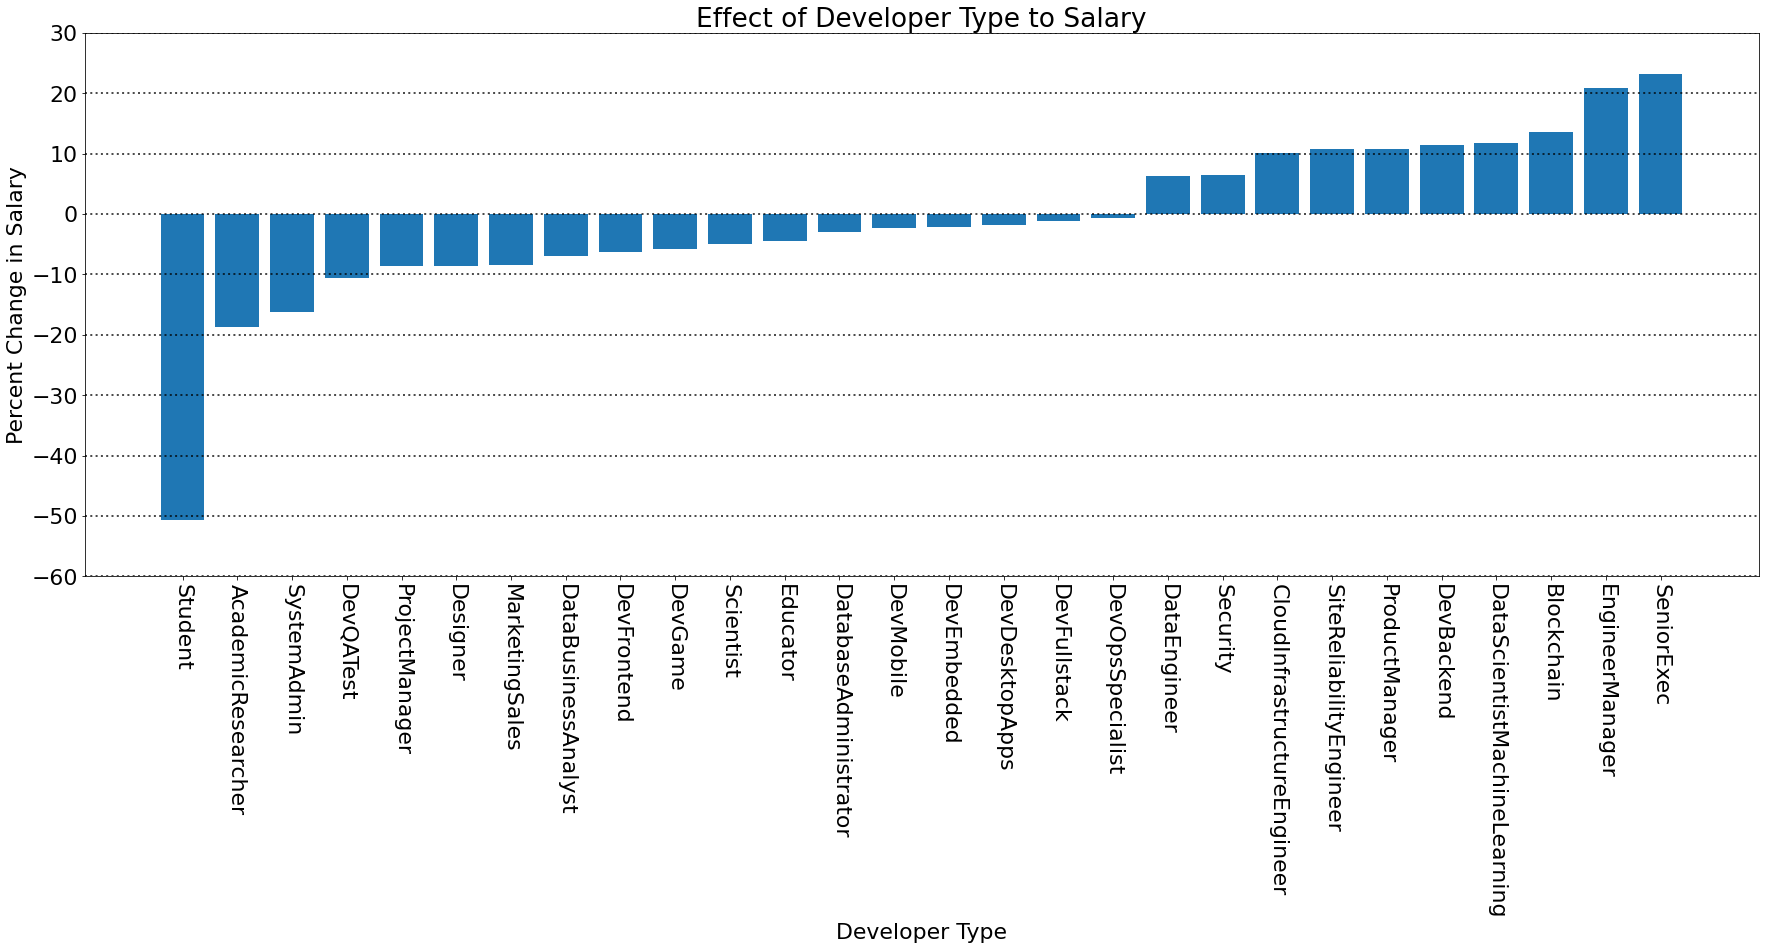

In [30]:
showCoefficientGraph(
  model_2,
  columns = cols(df_devtype),
  y_scale_factor=100,
  font_size=22,
  title="Effect of Developer Type to Salary",
  xlabel="Developer Type",
  ylabel="Percent Change in Salary"
).show()

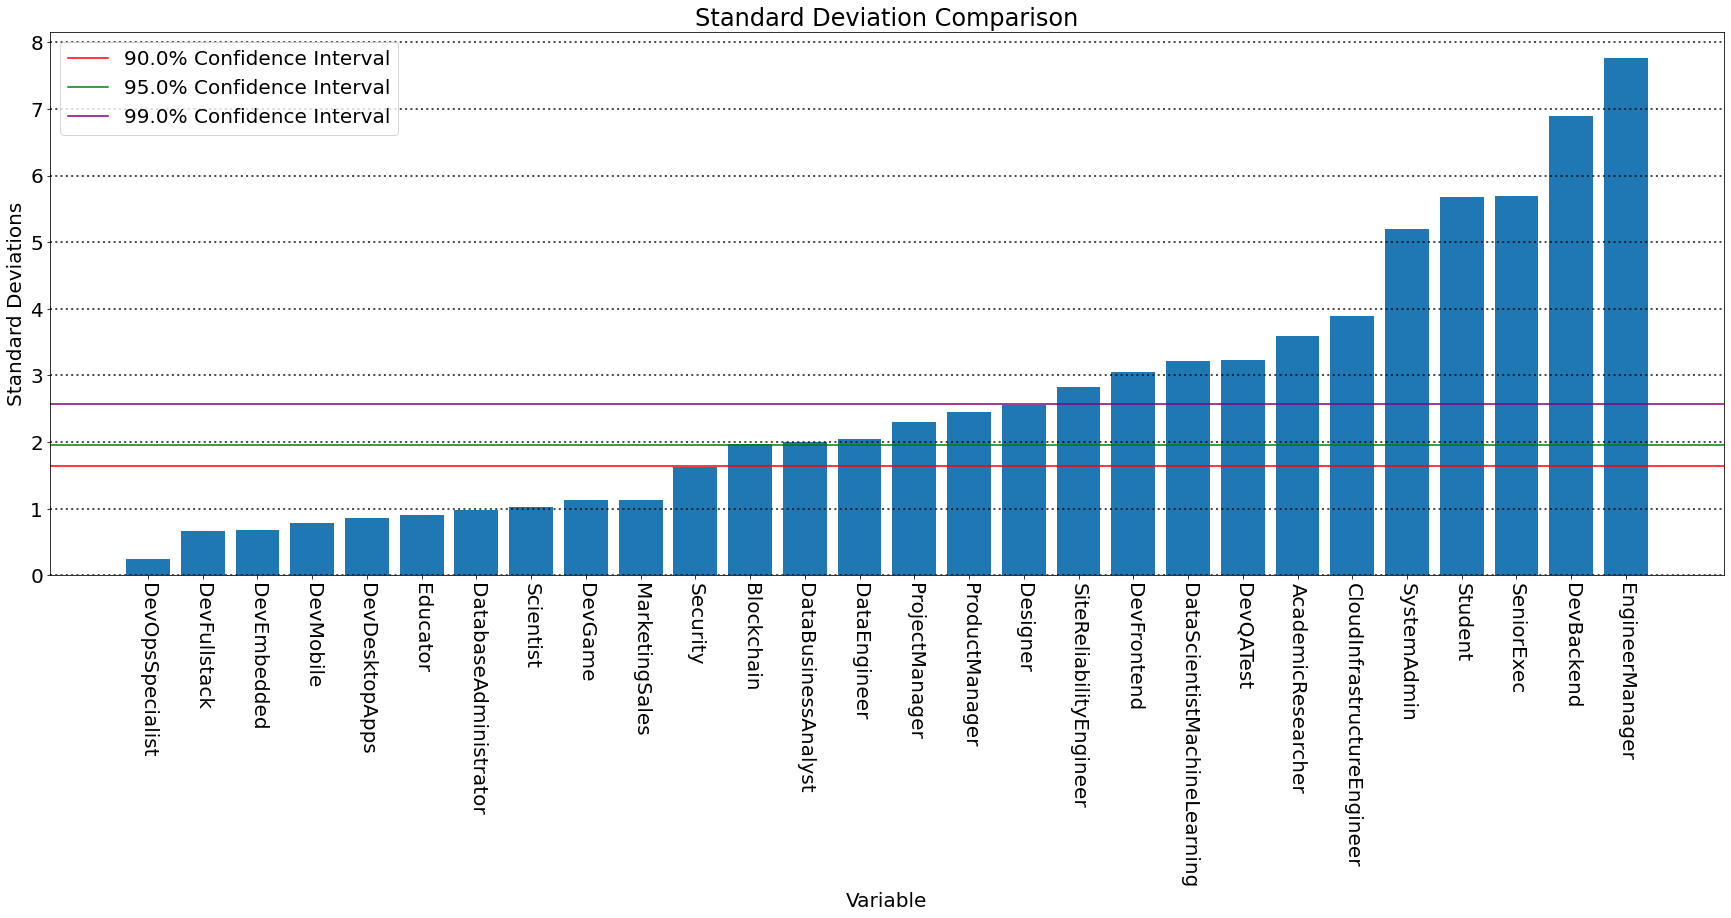

In [31]:
showCoefficientGraph(
  model_2,
  columns = cols(df_devtype),
  scale=False,
  show_stddev=True,
  title="Standard Deviation Comparison",
  ylabel="Standard Deviations",
  xlabel="Variable",
  font_size=20
).show()

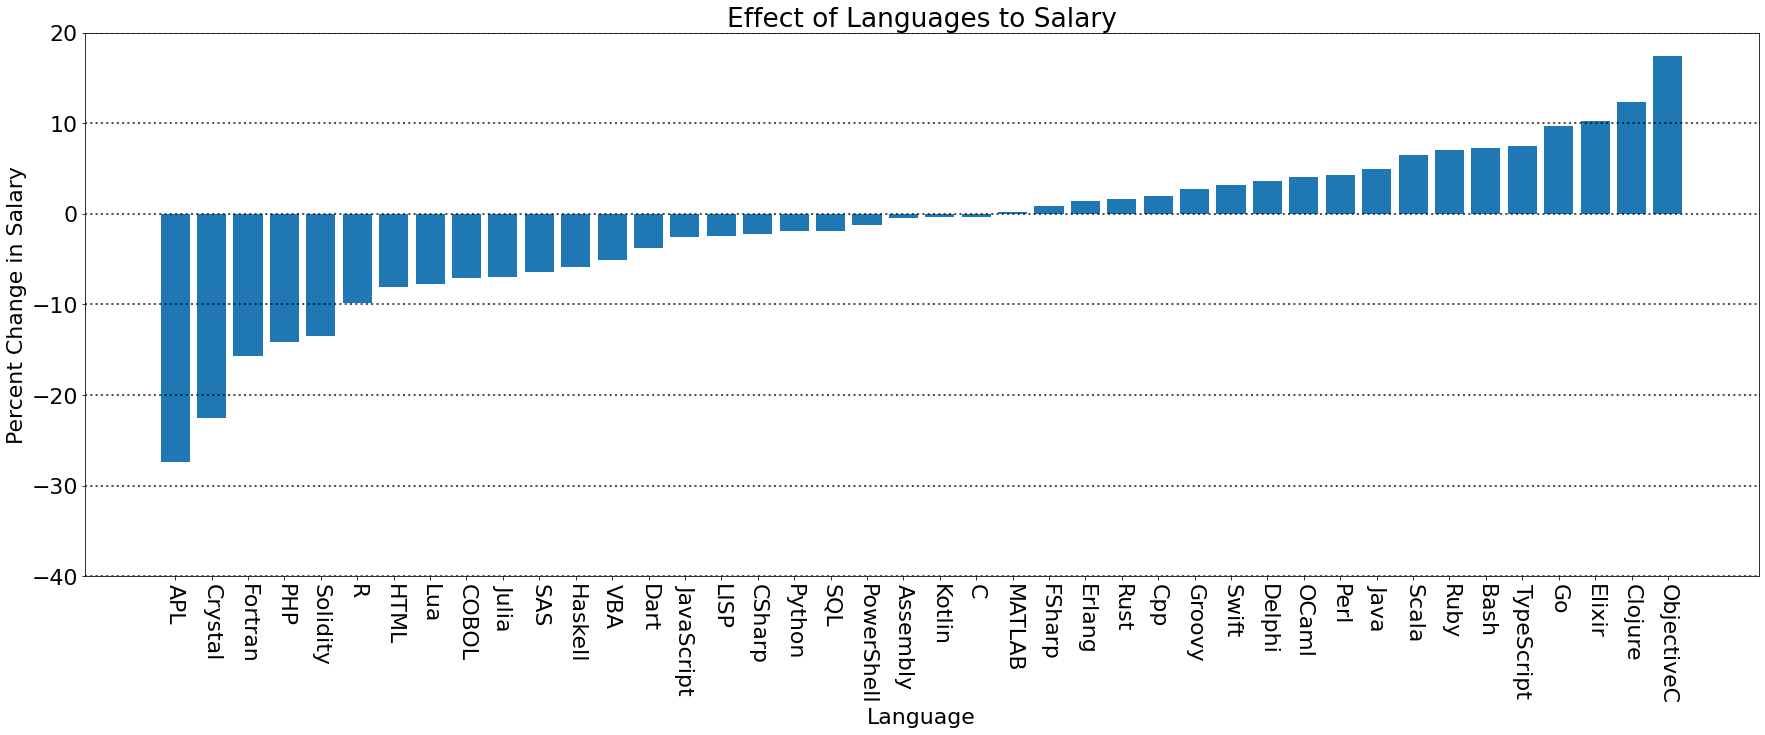

In [32]:
showCoefficientGraph(
  model_2,
  columns = cols(df_languages),
  y_scale_factor=100,
  font_size=22,
  title="Effect of Languages to Salary",
  xlabel="Language",
  ylabel="Percent Change in Salary"
).show()

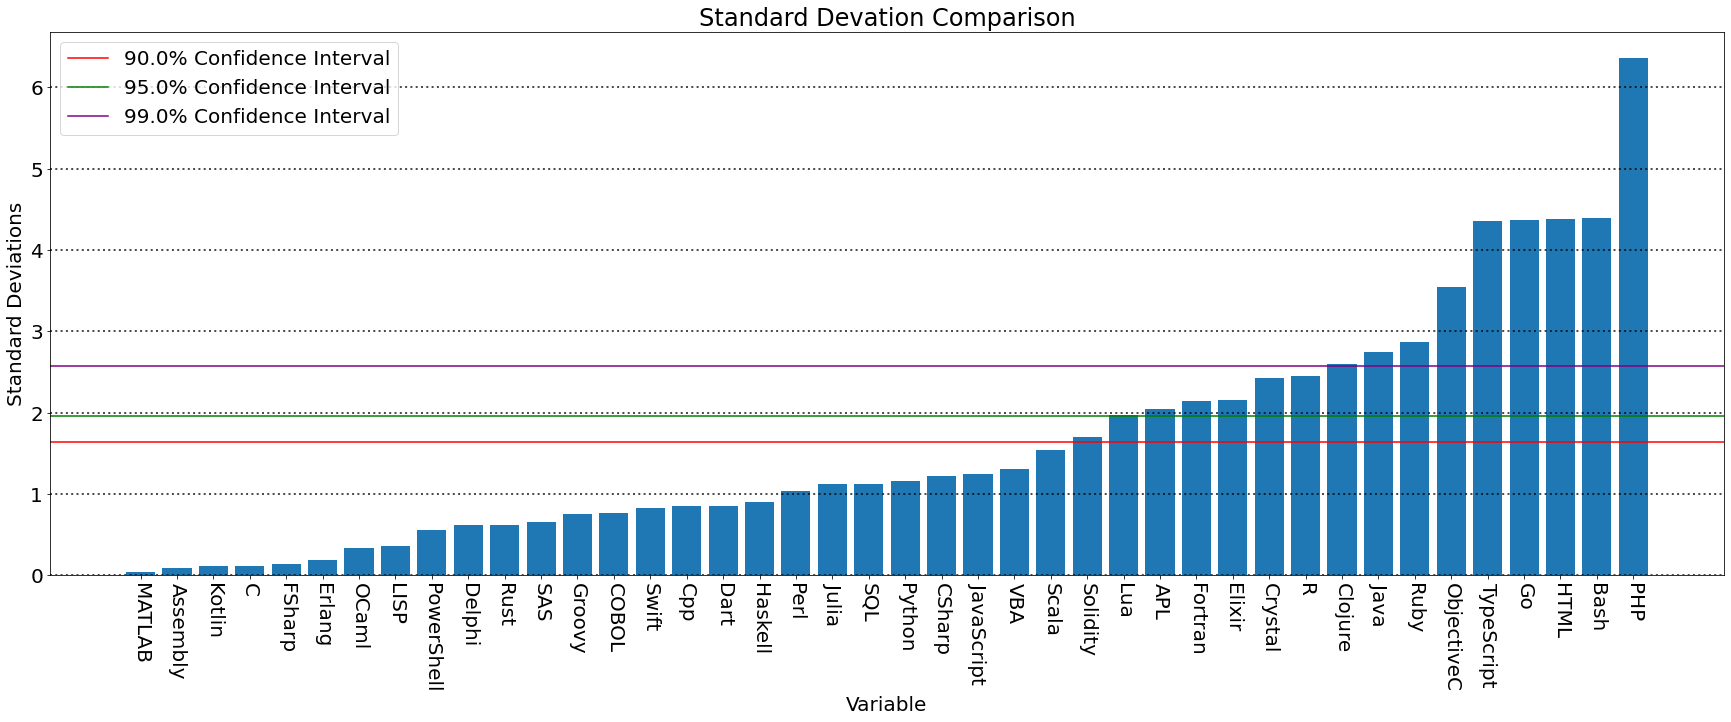

In [33]:
showCoefficientGraph(
  model_2,
  columns = cols(df_languages),
  scale=False,
  show_stddev=True,
  title="Standard Devation Comparison",
  ylabel="Standard Deviations",
  xlabel="Variable",
  font_size=20
).show()

In [34]:
model_3 = ols(f"np.log(ConvertedCompYearly) ~ {add(cols(df_languages) + cols(df_devtype) + ['Employed_FullTime', 'Employed_PartTime', 'NumYearsCodePro'])}", data = df_filtered).fit()

In [35]:
print(to_longtable(model_3.summary2().tables[1]))

\begin{longtable}{|R{0.4\linewidth}|R{0.3\linewidth}|R{0.3\linewidth}|}
\hline
\textbf{Coefficient} & \textbf{Coef.} & \textbf{Std.Err.} \\

\hline
$Intercept$ & $11.366365653609167$ & $0.04375120484297405$\\
\hline
$APL$ & $-0.294012690371091$ & $0.13060016341995073$\\
\hline
$Assembly$ & $0.00020107065128655753$ & $0.04378827469556922$\\
\hline
$Bash$ & $0.05882675826975049$ & $0.016135141527047786$\\
\hline
$C$ & $-0.01972502288268976$ & $0.02724721116535111$\\
\hline
$CSharp$ & $-0.04507076091612678$ & $0.01812521373478994$\\
\hline
$Cpp$ & $0.015992387946616293$ & $0.02316747157365949$\\
\hline
$COBOL$ & $-0.11377925158217876$ & $0.09094620051272745$\\
\hline
$Clojure$ & $0.09664941233814647$ & $0.04638728104770228$\\
\hline
$Crystal$ & $-0.2493065091787828$ & $0.0906135622732911$\\
\hline
$Dart$ & $-0.024061789165895502$ & $0.04303585045529357$\\
\hline
$Delphi$ & $-0.09985599716788493$ & $0.05837972733758297$\\
\hline
$Elixir$ & $0.0979823742731656$ & $0.046378906020531914$\\
\h

In [36]:
model_3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
=====================================================================================
Model:                 OLS                           Adj. R-squared:       0.131     
Dependent Variable:    np.log(ConvertedCompYearly)   AIC:                  16138.2939
Date:                  2022-12-17 18:13              BIC:                  16657.3630
No. Observations:      8221                          Log-Likelihood:       -7995.1   
Df Model:              73                            F-statistic:          18.01     
Df Residuals:          8147                          Prob (F-statistic):   2.57e-208 
R-squared:             0.139                         Scale:                0.41322   
-------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------
Intercept                            11.3664   0.0438 259.7955 0.0000 11.2806 11.4521
WorksIn_APL                          -0.2940   0.1306  -2.2512 0.0244 -0.5500 -0.0380
WorksIn_Assembly                      0.0002   0.0438   0.0046 0.9963 -0.0856  0.0860
WorksIn_Bash                          0.0588   0.0161   3.6459 0.0003  0.0272  0.0905
WorksIn_C                            -0.0197   0.0272  -0.7239 0.4691 -0.0731  0.0337
WorksIn_CSharp                       -0.0451   0.0181  -2.4866 0.0129 -0.0806 -0.0095
WorksIn_Cpp                           0.0160   0.0232   0.6903 0.4900 -0.0294  0.0614
WorksIn_COBOL                        -0.1138   0.0909  -1.2511 0.2109 -0.2921  0.0645
WorksIn_Clojure                       0.0966   0.0464   2.0835 0.0372  0.0057  0.1876
WorksIn_Crystal                      -0.2493   0.0906  -2.7513 0.0059 -0.4269 -0.0717
WorksIn_Dart                         -0.0241   0.0430  -0.5591 0.5761 -0.1084  0.0603
WorksIn_Delphi                       -0.0999   0.0584  -1.7105 0.0872 -0.2143  0.0146
WorksIn_Elixir                        0.0980   0.0464   2.1126 0.0347  0.0071  0.1889
WorksIn_Erlang                        0.0217   0.0723   0.3006 0.7637 -0.1201  0.1636
WorksIn_FSharp                       -0.0135   0.0590  -0.2294 0.8186 -0.1293  0.1022
WorksIn_Fortran                      -0.1764   0.0715  -2.4656 0.0137 -0.3166 -0.0361
WorksIn_Go                            0.0984   0.0218   4.5242 0.0000  0.0558  0.1411
WorksIn_Groovy                        0.0022   0.0350   0.0617 0.9508 -0.0665  0.0709
WorksIn_HTML                         -0.0643   0.0180  -3.5627 0.0004 -0.0997 -0.0289
WorksIn_Haskell                      -0.0315   0.0629  -0.5004 0.6168 -0.1549  0.0919
WorksIn_Java                          0.0436   0.0176   2.4732 0.0134  0.0090  0.0781
WorksIn_JavaScript                   -0.0184   0.0203  -0.9102 0.3627 -0.0582  0.0213
WorksIn_Julia                        -0.0516   0.0612  -0.8418 0.3999 -0.1716  0.0685
WorksIn_Kotlin                        0.0126   0.0294   0.4282 0.6685 -0.0451  0.0703
WorksIn_LISP                         -0.0481   0.0652  -0.7374 0.4609 -0.1759  0.0798
WorksIn_Lua                          -0.0648   0.0383  -1.6926 0.0906 -0.1399  0.0103
WorksIn_MATLAB                        0.0198   0.0475   0.4160 0.6774 -0.0733  0.1129
WorksIn_OCaml                         0.1449   0.1180   1.2282 0.2194 -0.0864  0.3763
WorksIn_ObjectiveC                    0.1564   0.0481   3.2538 0.0011  0.0622  0.2506
WorksIn_PHP                          -0.1382   0.0217  -6.3847 0.0000 -0.1807 -0.0958
WorksIn_Perl                         -0.0331   0.0401  -0.8262 0.4087 -0.1118  0.0455
WorksIn_PowerShell                   -0.0198   0.0211  -0.9377 0.3484 -0.0612  0.0216
WorksIn_Python                        0.0184   0.0161   1.1476 0.2511 -0.0131  0.0499
WorksIn_R                            -0.0772   0.0392  -1.9718 0.0487 -0.1540 -0.0005
WorksIn_Ruby          

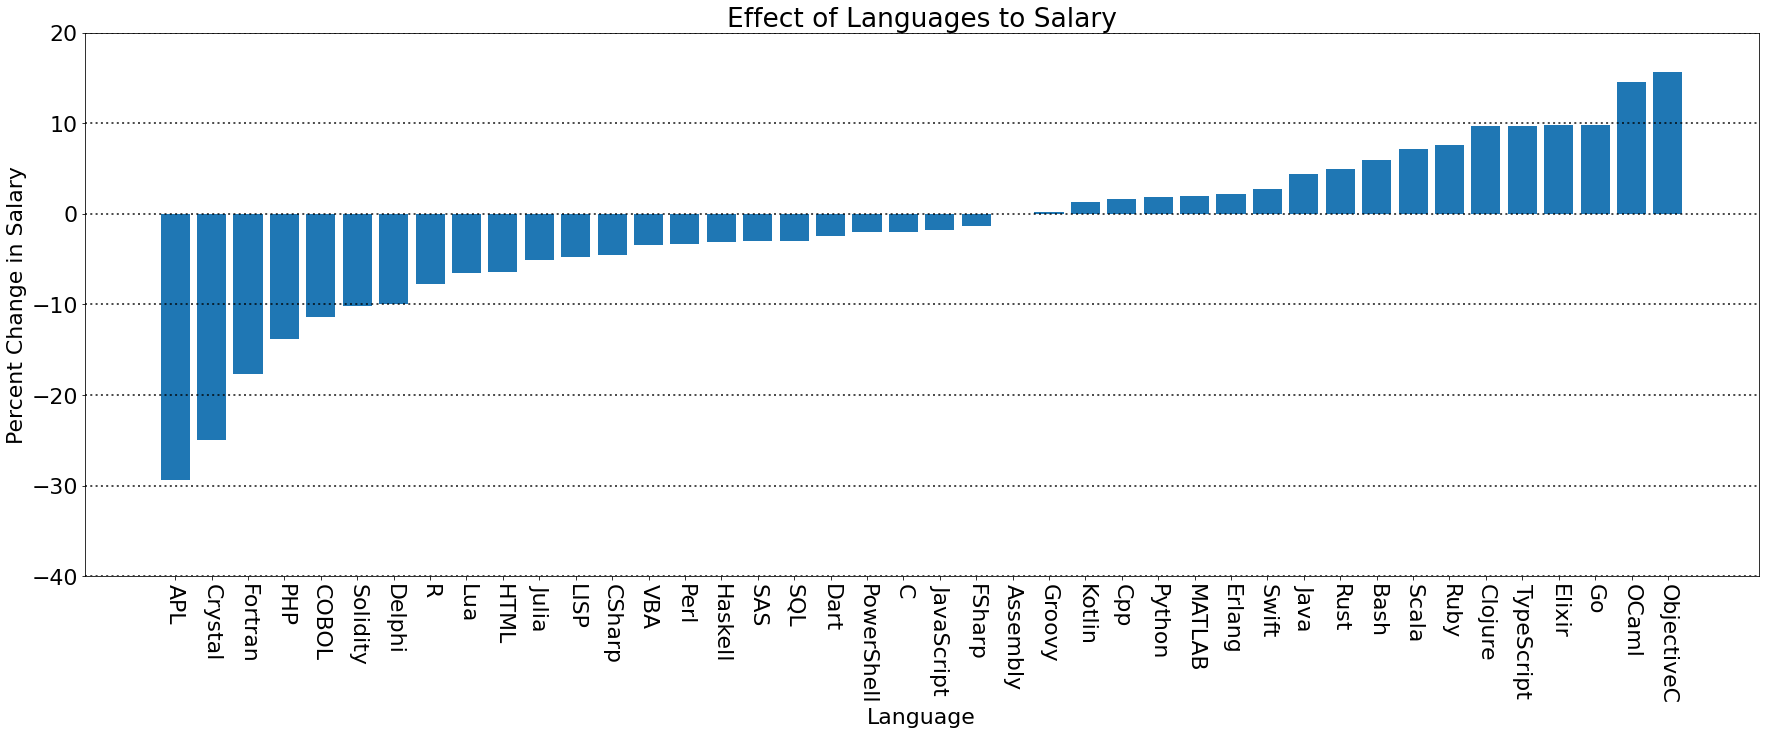

In [37]:
showCoefficientGraph(
  model_3,
  columns = cols(df_languages),
  y_scale_factor=100,
  font_size=22,
  title="Effect of Languages to Salary",
  xlabel="Language",
  ylabel="Percent Change in Salary"
).show()

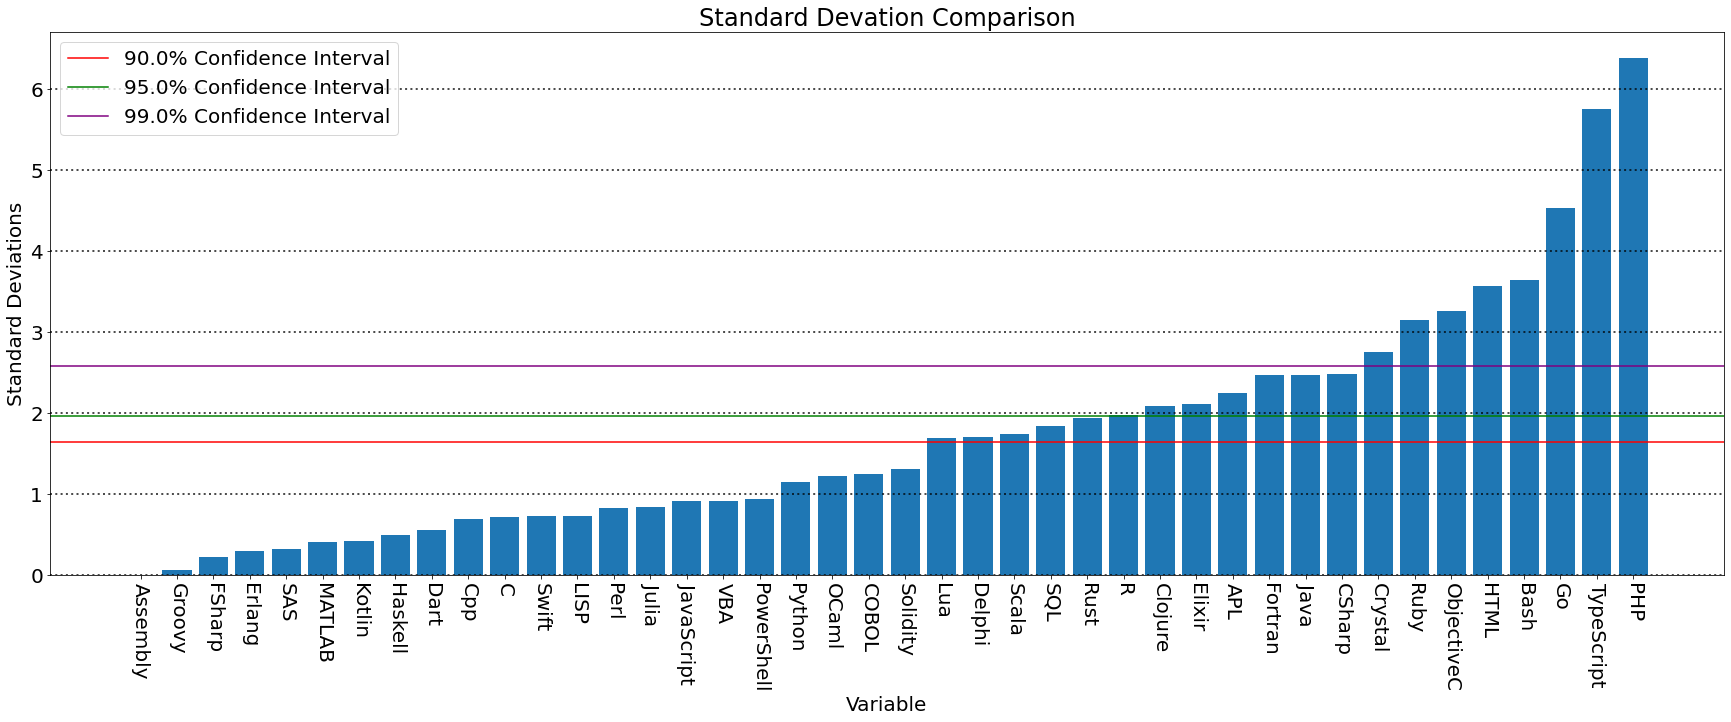

In [38]:
showCoefficientGraph(
  model_3,
  columns = cols(df_languages),
  scale=False,
  show_stddev=True,
  title="Standard Devation Comparison",
  ylabel="Standard Deviations",
  xlabel="Variable",
  font_size=20
).show()